<a href="https://colab.research.google.com/github/ShreyasJothish/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/DS41SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 1: Preprocessing

In [2]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [0]:
# Generic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [5]:
test.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [0]:
from datetime import date

def convert_risk_to_int(risk_str):
  if risk_str == "Risk 1 (High)":
    return 1
  elif risk_str == "Risk 2 (Medium)":
    return 2
  
  return 3

# Feature Engineering
def feature_engineering(df_input):
  df = df_input.copy()
  
  # Drop columns with no much information value add or very high cardinality
  df.drop(columns=['Inspection ID', 'DBA Name', 'AKA Name', 'Violations'], 
          inplace=True)
  
  # Convert Risk into Int
  df['Risk'] = df['Risk'].apply(convert_risk_to_int)
  
  # Fetch Year and Month from Inspection Date
  df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
  df['Inspection Year'] = df['Inspection Date'].dt.year
  df['Inspection Month'] = df['Inspection Date'].dt.month
  df['Inspection Day'] = df['Inspection Date'].dt.day
  df['Inspection Day of Week'] = df['Inspection Date'].dt.weekday
  
  df.drop(columns='Inspection Date', inplace=True)
  
  # Drop rows with NAs
  df.dropna(inplace=True)
  
  return df

In [0]:
# Perform feature engineering for both test and train dataset
train = feature_engineering(train)
test = feature_engineering(test)

In [8]:
# Split the data into independent and dependent variables
X_train = train.drop(columns='Fail')
y_train = train['Fail']
print(X_train.shape)
print(y_train.shape)

X_test = test.drop(columns='Fail')
y_test = test['Fail']
print(X_test.shape)
print(y_test.shape)

(51437, 15)
(51437,)
(17137, 15)
(17137,)


### Part 2: Modeling

In [9]:
# Used for Binary Encoding
!pip install category_encoders

In [0]:
# Using XGBClassifier with GridSearch CV with hyper parameter tuning
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [11]:
pipeline = make_pipeline(
    ce.BinaryEncoder(), 
    XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,
                  min_child_weight=1, gamma=0, subsample=0.8, 
                  colsample_bytree=0.8, objective= 'binary:logistic',
                  scale_pos_weight=1, reg_alpha = 0)
)

param_grid = {
    'xgbclassifier__max_depth':[4, 5, 6]
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=3,
                         scoring='roc_auc', verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xgbclassifier__max_depth=4, score=0.7138499528034871, total=  12.0s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=0.7147426656431289, total=  11.9s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.7s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=0.7184371643029119, total=  11.7s
[CV] xgbclassifier__max_depth=5 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.3s remaining:    0.0s


[CV]  xgbclassifier__max_depth=5, score=0.7169396610461366, total=  14.0s
[CV] xgbclassifier__max_depth=5 ......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.3s remaining:    0.0s


[CV]  xgbclassifier__max_depth=5, score=0.718175075221595, total=  14.0s
[CV] xgbclassifier__max_depth=5 ......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  xgbclassifier__max_depth=5, score=0.7239565436087723, total=  14.1s
[CV] xgbclassifier__max_depth=6 ......................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.4min remaining:    0.0s


[CV]  xgbclassifier__max_depth=6, score=0.7218061676751741, total=  16.4s
[CV] xgbclassifier__max_depth=6 ......................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[CV]  xgbclassifier__max_depth=6, score=0.7188525064510607, total=  16.5s
[CV] xgbclassifier__max_depth=6 ......................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.0min remaining:    0.0s


[CV]  xgbclassifier__max_depth=6, score=0.7264323671900772, total=  16.3s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('binaryencoder', BinaryEncoder(cols=None, drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, ma...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__max_depth': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [12]:
# Best cross validation score
print('Cross Validation Score:', gridsearch.best_score_)

# Best parameters which resulted in the best score
print('Best Parameters:', gridsearch.best_params_)

Cross Validation Score: 0.7223636587612714
Best Parameters: {'xgbclassifier__max_depth': 6}


In [13]:
y_pred_proba = gridsearch.predict_proba(X_test)[:, 1] 
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7371216951142344


### Part 3: Visualization

XGBoost does not work well with PDP plots so using RandomForestClassifier instead

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

Permutation Importance does not work well with pipeline

In [15]:
!pip install eli5

In [16]:
# Permutation Importance
import eli5
from eli5.sklearn import PermutationImportance

encoder = ce.BinaryEncoder()
X_train_transformed = encoder.fit_transform(X_train)
X_test_transformed = encoder.transform(X_test)

model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    min_samples_leaf=0.005, 
    n_jobs=-1)

model.fit(X_train_transformed, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', 
                                 n_iter=3, cv='prefit')
permuter.fit(X_train_transformed, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.005,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
           n_iter=3, random_state=None, refit=True, scoring='roc_auc')

In [17]:
eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.0820 ± 0.0044,Inspection Type_4
0.0729 ± 0.0024,Inspection Type_5
0.0308 ± 0.0016,Inspection Type_6
0.0211 ± 0.0023,Inspection Year
0.0156 ± 0.0026,License #
0.0112 ± 0.0007,Zip
0.0097 ± 0.0005,Latitude
0.0079 ± 0.0008,Longitude
0.0048 ± 0.0003,Inspection Month
0.0039 ± 0.0005,Risk


In [18]:
!pip install pdpbox

In [19]:
# PDP
y_pred_proba = model.predict_proba(X_test_transformed)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Validation ROC AUC: 0.6835193566602308


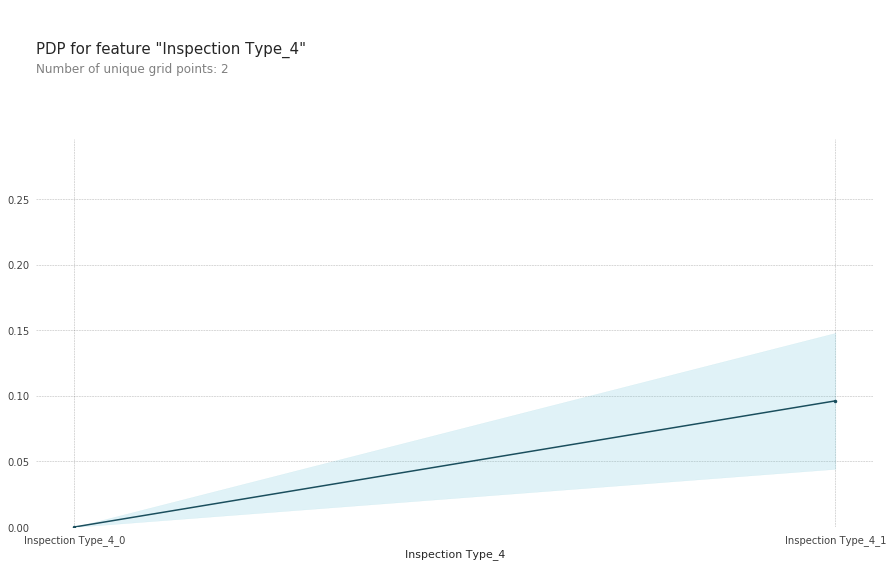

In [21]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Inspection Type_4'
pdp_isolated = pdp_isolate(model=model, dataset=X_test_transformed, 
                           model_features=X_test_transformed.columns, 
                           feature=feature)
pdp_plot(pdp_isolated, feature);